##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


## imdb_reviews
* 대형 영화 리뷰 데이터 세트
* 이진 감정 분류용 데이터 세트
* trian 25,000개
* test 25,000개
* unsupervised 50,000개
* 긍정 리뷰는 1, 부정 리뷰는 0

In [3]:
# with_info=True -> dataset과 metadata 반환
# as_supervised=True -> dataset을 dictionary로 반환
# as_supervised=False -> dataset을 tensor 형태로 반환
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
dataset

{Split('train'): <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('test'): <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('unsupervised'): <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [5]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        '

In [6]:
# x, y값에 대한 정보
# x : tf.string
# y : tf.int64
print(train_dataset)
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


Initially this returns a dataset of (text, label pairs):

In [11]:
# train의 x, y data
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [12]:
train_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
for example, label in train_dataset.take(10):
    print(example)
    print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [14]:
for example, label in train_dataset.take(5):
    print(example.numpy())
    print(label.numpy())

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development w

Next shuffle the data for training and create batches of these `(text, label)` pairs:

### shuffle()
* [참고 자료](https://helloyjam.github.io/tensorflow/buffer-size-in-shuffle/)
* [참고 자료](https://doubly8f.netlify.app/%EA%B0%9C%EB%B0%9C/2020/08/19/tf-loading-preprocessing-data/)
* 경사 하강법은 훈련 세트에 있는 샘플이 독립적이고 동일한 분포일 때 최고의 성능 발휘
* shuffle을 통해 train set을 독립적이고, 동일한 분포로 만듦

<br>

* buffer
* 임시 저장 공간
* A와 B가 서로 입출력을 수행하는데 있어 속도차이를 극복하기 위해 사용하는 임시 저장 공간

<br>

* 원본 데이터셋의 첫 아이템을 buffer_size 개수만큼 추출하여 버퍼에 채움
* 버퍼에서 랜덤하게 하나씩 반환
* 원본 데이터셋에서 새로운 아이템을 추출하여 비워진 버퍼 채움
* 원본 데이터셋의 모든 아이템 사용될 때까지 반복
* 버퍼가 비워질 때까지 계속하여 랜덤하게 아이템 반환

<br>

* 완벽한 셔플링 위해서 버퍼크기가 데이터셋의 크기와 동일해야 함
* 사전에 파일이름과 label을 shuffle 해서 dataset을 만든다.

<br>

* prefetch
* 학습 중, 데이터 로드시간을 줄이기 위해 미리 메모리에 적재
* 괄호안에 얼만큼 적재시킬지에 대한 숫자 입력
* tf.data.AUTOTUNE : 네트워크가 알아서 설정

In [15]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [16]:
# shuffle : 범위(buffer_size)에서 데이터를 섞어줌
# batch : shuffle 된 범위 안에서 데이터 선정
# prefetch : 훈련 최대 스텝시간과 데이터 추출하는데 걸리는 시간 단축
# 데이터를 불러오고 학습하는데 시간을 단축시키는 역할

In [17]:
# shuffle : 첫 10,000개의 데이터를 buffer에 가져옴
# batch : 10,000개 중 64개를 pick
# prefetch : 네트워크가 알아서 임시 저장소에 쟁여둬
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Let's just say it in simple words so that even the makers of this film might have a chance to understand: This is a very dumb film with an even dumber script, lame animation, and a story that's about as original as thumbtacks. Don't bother -- unless you need to find some way to entertain a group of mentally retarded adults or extremely slow children. They might laugh, especially if they're off their meds. There's a special kind of insult in a film this ridiculous -- not only do the filmmakers apparently think that children are brainless idiots who can be entertained with claptrap that cost approximately zero effort, but they don't even bother to break a sweat inserting a gag here and there that an adult might find amusing. This film, frankly, ticked me off royally. Shame on you for stooping so low."
 b'This film is a flagrant rip-off of one of the best novels of all time, Silas Marner by George Eliot.<br /><br />The details of the film shown on IMDb do give acknowledgement t

In [19]:
# 임시 저장소에서 하나씩 가져올 때마다 64씩 가져오는 모습 
for example, label in train_dataset.take(1):
  print('texts: ', len(example.numpy()))
  print('labels: ', len(label.numpy()))

texts:  64
labels:  64


In [20]:
for example, label in train_dataset.take(3):
  print("-----new temp-----")
  print('texts: ', len(example.numpy()))
  print('labels: ', len(label.numpy()))
  print()

-----new temp-----
texts:  64
labels:  64

-----new temp-----
texts:  64
labels:  64

-----new temp-----
texts:  64
labels:  64



In [21]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy())
  print()
  print('labels: ', label.numpy())

texts:  [b"Firstly I would like to point out that I only know of the show due to my younger sister always watching it. I find it the most annoying program on TV. There is nothing funny about any of the 'jokes' and the canned laughter is unbearable. The show would work much better if filmed in front of a live audience. That way the laughter would show just how 'unfunny' the show is. However I give credit to the acting talents of the young cast. It sickens me however to think that they'll look back on the show in the future and see how bad their first TV show was. The show links in well with the overall annoying voices and style of the CBBC presenters. Why the youth of today need to be shouted at so much is beyond me. That is all."
 b"Wow! This film is truly awful. I can't imagine how anyone could have read this badly written script and given it the greenlight. The cast is uniformly second rate with some truly horrendous performances from virtually all of the cast. The story is disjointe

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

### TextVectorization
* [공식 문서](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt)
* [참고 자료](https://dodonam.tistory.com/188)
* 텍스트 데이터를 벡터화 하는 내장 함수
    * 파라미터
        * `max_tokens`
            * 전체 단어 사전 크기


In [22]:
train_dataset.map(lambda text, label: text)

<MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [23]:
# 단어 행렬의 열 개수를 1,000개로 제한
# 최대 단어 수
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# 단어 사전을 만들기 위해서 text만 필요, label은 필요하지 않음
# lambda text, label: text
# text만 가져옴
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [24]:
# [UNK], unknown : 단어장에 없는 단어
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [25]:
# 단어 개수
len(vocab)

1000

In [26]:
# 추출된 단어들
vocab

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be',
       'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so',
       'like', 'her', 'just', 'or', 'about', 'has', 'if', 'out', 'some',
       'there', 'what', 'good', 'when', 'more', 'very', 'even', 'she',
       'my', 'no', 'up', 'would', 'which', 'only', 'time', 'really',
       'story', 'their', 'were', 'had', 'see', 'can', 'me', 'than', 'we',
       'much', 'well', 'been', 'get', 'will', 'into', 'also', 'because',
       'other', 'do', 'people', 'bad', 'great', 'first', 'how', 'most',
       'him', 'dont', 'made', 'then', 'movies', 'make', 'films', 'could',
       'way', 'them', 'any', 'too', 'after', 'characters', 'think',
       'watch', 'two', 'many', 'being', 'seen', 'character', 'never',
       'little', 'acting', 'where', 'plot', 'best', 'love', 'did'

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [27]:
example[0]

<tf.Tensor: shape=(), dtype=string, numpy=b"Firstly I would like to point out that I only know of the show due to my younger sister always watching it. I find it the most annoying program on TV. There is nothing funny about any of the 'jokes' and the canned laughter is unbearable. The show would work much better if filmed in front of a live audience. That way the laughter would show just how 'unfunny' the show is. However I give credit to the acting talents of the young cast. It sickens me however to think that they'll look back on the show in the future and see how bad their first TV show was. The show links in well with the overall annoying voices and style of the CBBC presenters. Why the youth of today need to be shouted at so much is beyond me. That is all.">

In [28]:
label[0]

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [29]:
# 이건 뭐하는 코드지
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 1, 10, 59, ...,  0,  0,  0],
       [ 1, 11, 20, ...,  0,  0,  0],
       [49,  7,  1, ...,  0,  0,  0]])

In [30]:
import pandas as pd

pd.DataFrame(encoded_example)

,0,1,2,3,4,5,6,7,8,9,...,888,889,890,891,892,893,894,895,896,897
0,1,10,59,39,6,215,46,12,10,61,...,0,0,0,0,0,0,0,0,0,0
1,1,11,20,7,353,381,10,175,823,87,...,0,0,0,0,0,0,0,0,0,0
2,49,7,1,1,39,9,7,316,85,3,...,0,0,0,0,0,0,0,0,0,0


In [40]:
vocab[10], vocab[59], vocab[39], vocab[6], vocab[215]

('i', 'would', 'like', 'to', 'point')

In [66]:
encoded_example.shape

(3, 567)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [16]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"(Spoiler included, some would say)<br /><br />This film is not possible to take seriously. At some parts it is so awfully stupid that I just can't help laughing at it all. Try me for the sequence where Stallone's character jumps some 20 meters with full climbing gear or (and this is really my favorite) snuffs a bad guy by sticking him onto a stalactite. Yeah, what ungodly strength did he muster to accomplish such feats? I dunno, but he sure gives reality a run for the money."
Round-trip:  [UNK] [UNK] some would [UNK] br this film is not possible to take seriously at some parts it is so [UNK] stupid that i just cant help [UNK] at it all try me for the sequence where [UNK] character [UNK] some 20 [UNK] with full [UNK] [UNK] or and this is really my favorite [UNK] a bad guy by [UNK] him [UNK] a [UNK] [UNK] what [UNK] [UNK] did he [UNK] to [UNK] such [UNK] i [UNK] but he sure gives reality a run for the money                                                                     

In [75]:
# 인코딩 전
print(type(example[0].numpy()))
example[0].numpy()

<class 'bytes'>


b"Well, how do you even rate a movie such as this one? Does it even have cinematic value really? It's a movie that tries to get as close to being a snuff movie as possible. Basically the entire movie is purely a bunch of guys torturing a young girl. Not very appealing and on top of that also not that realistic really.<br /><br />It's obvious that the movie tried to be as realistic and shocking as possible. However the movie is just all too fake for that to work out as intended. The slapping and stumping is all soft and fake looking, as well as sounding. They are often just kicking into the floor, rather than into the girl, obviously. Also the way the girl responds to all the torments is pretty tame. I mean if this was real, surely she would had screamed it out. There is more moaning than screaming in this one though.<br /><br />The movie is obviously low budget and it's a valor attempt at trying to achieve something shocking and realistic as well as original and provoking, with very li

In [76]:
# 인코딩 후
# 달라진 점
# 누락 단어 보임 -> [UNK]로 표현
# 특수 문자 다 사라짐
# 소문자로 통일
print(type(" ".join(vocab[encoded_example[0]])))
" ".join(vocab[encoded_example[0]])

<class 'str'>


'well how do you even [UNK] a movie such as this one does it even have [UNK] [UNK] really its a movie that tries to get as close to being a [UNK] movie as possible basically the entire movie is [UNK] a bunch of guys [UNK] a young girl not very [UNK] and on top of that also not that realistic [UNK] br its obvious that the movie tried to be as realistic and [UNK] as possible however the movie is just all too [UNK] for that to work out as [UNK] the [UNK] and [UNK] is all [UNK] and [UNK] looking as well as [UNK] they are often just [UNK] into the [UNK] rather than into the girl obviously also the way the girl [UNK] to all the [UNK] is pretty [UNK] i mean if this was real [UNK] she would had [UNK] it out there is more [UNK] than [UNK] in this one [UNK] br the movie is obviously low budget and its a [UNK] attempt at trying to [UNK] something [UNK] and realistic as well as original and [UNK] with very [UNK] [UNK] dont really think this movie made much [UNK] though at the time it got released 

In [72]:
vocab[encoded_example[0]]

array(['well', 'how', 'do', 'you', 'even', '[UNK]', 'a', 'movie', 'such',
       'as', 'this', 'one', 'does', 'it', 'even', 'have', '[UNK]',
       '[UNK]', 'really', 'its', 'a', 'movie', 'that', 'tries', 'to',
       'get', 'as', 'close', 'to', 'being', 'a', '[UNK]', 'movie', 'as',
       'possible', 'basically', 'the', 'entire', 'movie', 'is', '[UNK]',
       'a', 'bunch', 'of', 'guys', '[UNK]', 'a', 'young', 'girl', 'not',
       'very', '[UNK]', 'and', 'on', 'top', 'of', 'that', 'also', 'not',
       'that', 'realistic', '[UNK]', 'br', 'its', 'obvious', 'that',
       'the', 'movie', 'tried', 'to', 'be', 'as', 'realistic', 'and',
       '[UNK]', 'as', 'possible', 'however', 'the', 'movie', 'is', 'just',
       'all', 'too', '[UNK]', 'for', 'that', 'to', 'work', 'out', 'as',
       '[UNK]', 'the', '[UNK]', 'and', '[UNK]', 'is', 'all', '[UNK]',
       'and', '[UNK]', 'looking', 'as', 'well', 'as', '[UNK]', 'they',
       'are', 'often', 'just', '[UNK]', 'into', 'the', '[UNK]', 'rathe

In [69]:
len(example)

64

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

### LSTM의 역할
* 유사한 맥락에 나타난 단어들끼리는 두 단어 벡터 사이의 거리를 가깝게 하고
* 그렇지 않은 단어들끼리는 멀어지게 조금씩 조정

In [17]:
model = tf.keras.Sequential([
    encoder,
    # Embedding 과정이 필요한 이유 -> 각 단어를 encoder를 지정된 차원으로 벡터화시켜주기 위함
    # 분포 가설에 따라 모든 단어를 고정 차원(64차원)의 벡터로 표현
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    # 양방향 RNN
    # 앞 단어만으로 문장 추론 힘든 경우 많음
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [18]:
# model 총 5개의 layer, encoder도 layer
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [19]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[-0.00797682]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [20]:
# predict on a sample text with padding
# padding을 넣어도 같은 결과
# model.layer.Embedding(mask_zero=True) 파라미터로 가능한 일

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 146ms/step
[-0.00797682]


Compile the Keras model to configure the training process:

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [22]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 41s 86ms/step - loss: 0.6490 - accuracy: 0.5616 - val_loss: 0.5154 - val_accuracy: 0.6964
Epoch 2/10
391/391 [==============================] - 31s 79ms/step - loss: 0.4565 - accuracy: 0.7752 - val_loss: 0.4135 - val_accuracy: 0.8266
Epoch 3/10
391/391 [==============================] - 32s 80ms/step - loss: 0.3770 - accuracy: 0.8323 - val_loss: 0.3600 - val_accuracy: 0.8396
Epoch 4/10
391/391 [==============================] - 31s 80ms/step - loss: 0.3403 - accuracy: 0.8540 - val_loss: 0.3587 - val_accuracy: 0.8292
Epoch 5/10
391/391 [==============================] - 31s 80ms/step - loss: 0.3236 - accuracy: 0.8624 - val_loss: 0.3339 - val_accuracy: 0.8620
Epoch 6/10
391/391 [==============================] - 31s 80ms/step - loss: 0.3124 - accuracy: 0.8668 - val_loss: 0.3313 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3063 - accuracy: 0.8710 - val_loss: 0.3385 - val_accuracy:

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 17s 44ms/step - loss: 0.3159 - accuracy: 0.8611
Test Loss: 0.3158537745475769
Test Accuracy: 0.8611199855804443


(0.0, 0.6666609242558479)

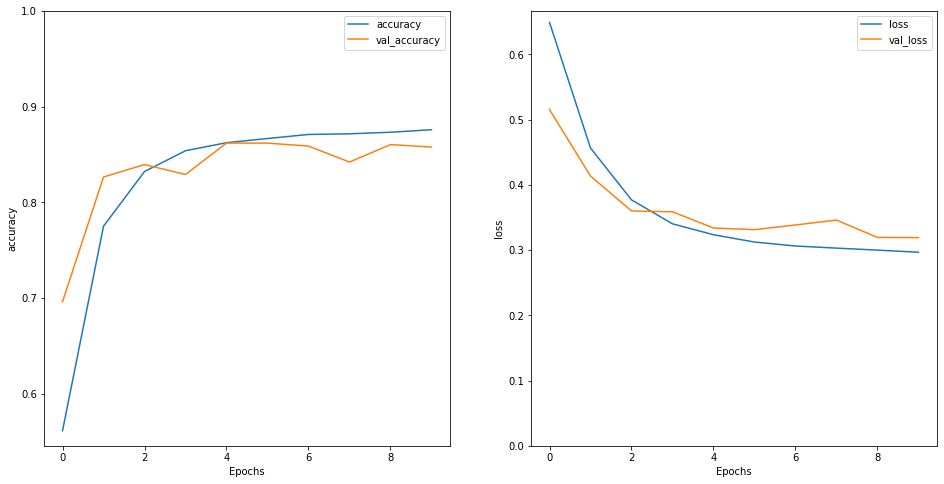

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [25]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [26]:
model = tf.keras.Sequential([
    encoder,
    # 이중 RNN
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 70s 146ms/step - loss: 0.6188 - accuracy: 0.5958 - val_loss: 0.4275 - val_accuracy: 0.8026
Epoch 2/10
391/391 [==============================] - 58s 147ms/step - loss: 0.3827 - accuracy: 0.8352 - val_loss: 0.3567 - val_accuracy: 0.8469
Epoch 3/10
391/391 [==============================] - 53s 134ms/step - loss: 0.3362 - accuracy: 0.8558 - val_loss: 0.3381 - val_accuracy: 0.8557
Epoch 4/10
391/391 [==============================] - 54s 138ms/step - loss: 0.3227 - accuracy: 0.8629 - val_loss: 0.3301 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 54s 137ms/step - loss: 0.3125 - accuracy: 0.8672 - val_loss: 0.3238 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 53s 134ms/step - loss: 0.3059 - accuracy: 0.8696 - val_loss: 0.3280 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 60s 153ms/step - loss: 0.3029 - accuracy: 0.8722 - val_loss: 0.3302 - val_ac

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 29s 74ms/step - loss: 0.3133 - accuracy: 0.8572
Test Loss: 0.3132984936237335
Test Accuracy: 0.8572400212287903


In [30]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-1.7926306]]


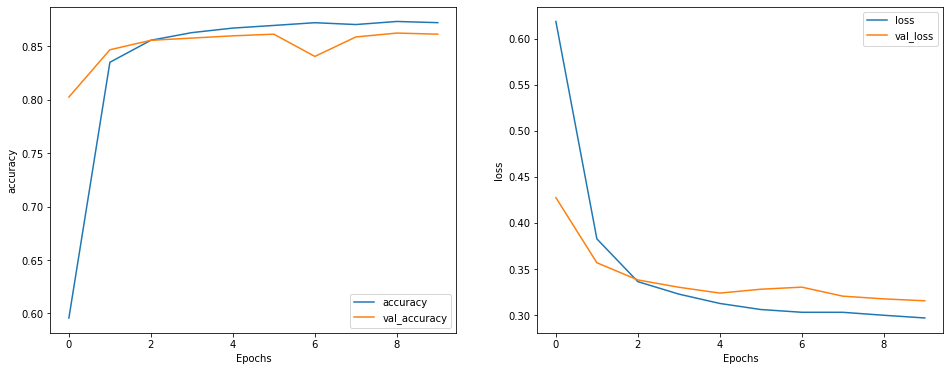

In [31]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
